# Method 4 - Best Ideas High Liquidity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Market Cap Adjusted Target

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance Adjusted Intra-Cap Weight Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data[
    'weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Get Liquidity

distinct_ideas = best_ideas[['datadate', 'fsym_id']].drop_duplicates()
distinct_ideas['in'] = 1

bid_asks = crsp.get_crsp_fsym_bid_ask(list(set(distinct_ideas['fsym_id'].dropna())),
                                      distinct_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
bid_asks['rel_bid_ask'] = (bid_asks['ask'] - bid_asks['bid']) / ((bid_asks['bid'] + bid_asks['ask']) / 2)
bid_asks['datadate'] = bid_asks['datadate'] + pd.offsets.QuarterEnd(0)
qe_bid_asks = bid_asks.groupby(['datadate', 'fsym_id'])['rel_bid_ask'].mean().reset_index()
qe_bid_asks = qe_bid_asks.merge(distinct_ideas)

qe_bid_asks['median_bid_ask'] = qe_bid_asks.groupby('datadate')['rel_bid_ask'].transform('median')
qe_bid_asks = qe_bid_asks[qe_bid_asks['rel_bid_ask'] < qe_bid_asks['median_bid_ask']]

best_ideas = best_ideas.merge(qe_bid_asks)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

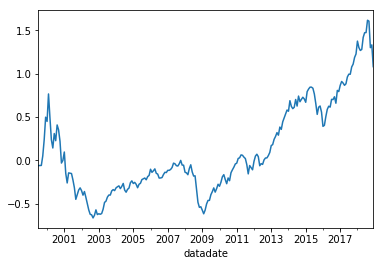

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.497904
2000-12-31   -0.332239
2001-12-31   -0.315812
2002-12-31   -0.448842
2003-12-31    0.730785
2004-12-31    0.171751
2005-12-31    0.082073
2006-12-31    0.039964
2007-12-31    0.098324
2008-12-31   -0.506072
2009-12-31    0.554162
2010-12-31    0.321932
2011-12-31   -0.069728
2012-12-31    0.224068
2013-12-31    0.446698
2014-12-31    0.080762
2015-12-31   -0.089017
2016-12-31    0.152055
2017-12-31    0.241308
2018-12-31   -0.065419
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     475.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.14e-109
Time:                        12:43:45   Log-Likelihood:                 541.88
No. Observations:                 234   AIC:                            -1074.
Df Residuals:                     229   BIC:                            -1056.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.648      0.101      -0.001       0.006
mktrf          1.0921      0.045     24.256      0.000       1.003       1.181
me             0.4574      0.052      8.733      0.000       0.354       0.561
ia            -0.5812      0.080     -7.301      0.000      -0.738      -0.424
roe           -0.5103      0.068     -7.490      0.000      -0.645      -0.376
==============================================================================
Omnibus:                       17.494   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.607
Skew:                          -0.107   Prob(JB):                     1.39e-12
Kurtosis:                       5.357   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     268.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.43e-85
Time:                        12:43:46   Log-Likelihood:                 541.88
No. Observations:                 234   AIC:                            -1074.
Df Residuals:                     229   BIC:                            -1056.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.535      0.125      -0.001       0.006
mktrf          1.0921      0.059     18.593      0.000       0.977       1.207
me             0.4574      0.093      4.943      0.000       0.276       0.639
ia            -0.5812      0.131     -4.423      0.000      -0.839      -0.324
roe           -0.5103      0.120     -4.263      0.000      -0.745      -0.276
==============================================================================
Omnibus:                       17.494   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.607
Skew:                          -0.107   Prob(JB):                     1.39e-12
Kurtosis:                       5.357   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     281.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.35e-87
Time:                        12:43:46   Log-Likelihood:                 541.88
No. Observations:                 234   AIC:                            -1074.
Df Residuals:                     229   BIC:                            -1056.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.575      0.115      -0.001       0.006
mktrf          1.0921      0.048     22.984      0.000       0.999       1.185
me             0.4574      0.092      4.974      0.000       0.277       0.638
ia            -0.5812      0.123     -4.725      0.000      -0.822      -0.340
roe           -0.5103      0.117     -4.368      0.000      -0.739      -0.281
==============================================================================
Omnibus:                       17.494   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.607
Skew:                          -0.107   Prob(JB):                     1.39e-12
Kurtosis:                       5.357   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     461.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.08e-117
Time:                        12:43:46   Log-Likelihood:                 562.73
No. Observations:                 234   AIC:                            -1113.
Df Residuals:                     228   BIC:                            -1093.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.002      1.828      0.069      -0.000       0.006
mktrf          1.1405      0.041     27.578      0.000       1.059       1.222
smb            0.4331      0.055      7.937      0.000       0.326       0.541
hml           -0.2768      0.064     -4.301      0.000      -0.404      -0.150
rmw           -0.5954      0.073     -8.184      0.000      -0.739      -0.452
cma           -0.0750      0.092     -0.811      0.418      -0.257       0.107
==============================================================================
Omnibus:                        9.714   Durbin-Watson:                   1.639
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               15.865
Skew:                          -0.213   Prob(JB):                     0.000359
Kurtosis:                       4.202   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     331.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.09e-102
Time:                        12:43:46   Log-Likelihood:                 562.73
No. Observations:                 234   AIC:                            -1113.
Df Residuals:                     228   BIC:                            -1093.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      1.964      0.050    5.45e-06       0.006
mktrf          1.1405      0.049     23.361      0.000       1.045       1.236
smb            0.4331      0.044      9.937      0.000       0.348       0.519
hml           -0.2768      0.087     -3.191      0.001      -0.447      -0.107
rmw           -0.5954      0.083     -7.132      0.000      -0.759      -0.432
cma           -0.0750      0.135     -0.555      0.579      -0.340       0.190
==============================================================================
Omnibus:                        9.714   Durbin-Watson:                   1.639
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               15.865
Skew:                          -0.213   Prob(JB):                     0.000359
Kurtosis:                       4.202   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     418.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.20e-112
Time:                        12:43:46   Log-Likelihood:                 562.73
No. Observations:                 234   AIC:                            -1113.
Df Residuals:                     228   BIC:                            -1093.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.120      0.034       0.000       0.005
mktrf          1.1405      0.052     21.739      0.000       1.038       1.243
smb            0.4331      0.041     10.507      0.000       0.352       0.514
hml           -0.2768      0.077     -3.585      0.000      -0.428      -0.125
rmw           -0.5954      0.083     -7.162      0.000      -0.758      -0.432
cma           -0.0750      0.128     -0.583      0.560      -0.327       0.177
==============================================================================
Omnibus:                        9.714   Durbin-Watson:                   1.639
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               15.865
Skew:                          -0.213   Prob(JB):                     0.000359
Kurtosis:                       4.202   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     450.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.23e-107
Time:                        12:43:46   Log-Likelihood:                 536.10
No. Observations:                 234   AIC:                            -1062.
Df Residuals:                     229   BIC:                            -1045.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.096e-05      0.002     -0.031      0.975      -0.003       0.003
mktrf          1.2684      0.042     29.851      0.000       1.185       1.352
smb            0.6418      0.053     12.100      0.000       0.537       0.746
hml           -0.4067      0.053     -7.719      0.000      -0.511      -0.303
umd           -0.0801      0.035     -2.318      0.021      -0.148      -0.012
==============================================================================
Omnibus:                       10.598   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               22.215
Skew:                          -0.083   Prob(JB):                     1.50e-05
Kurtosis:                       4.500   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     243.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.66e-81
Time:                        12:43:46   Log-Likelihood:                 536.10
No. Observations:                 234   AIC:                            -1062.
Df Residuals:                     229   BIC:                            -1045.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.096e-05      0.002     -0.030      0.976      -0.003       0.003
mktrf          1.2684      0.060     21.269      0.000       1.151       1.385
smb            0.6418      0.082      7.872      0.000       0.482       0.802
hml           -0.4067      0.077     -5.308      0.000      -0.557      -0.257
umd           -0.0801      0.056     -1.429      0.153      -0.190       0.030
==============================================================================
Omnibus:                       10.598   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               22.215
Skew:                          -0.083   Prob(JB):                     1.50e-05
Kurtosis:                       4.500   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     201.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.55e-74
Time:                        12:43:46   Log-Likelihood:                 536.10
No. Observations:                 234   AIC:                            -1062.
Df Residuals:                     229   BIC:                            -1045.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.096e-05      0.002     -0.034      0.973      -0.003       0.003
mktrf          1.2684      0.065     19.576      0.000       1.141       1.395
smb            0.6418      0.072      8.949      0.000       0.501       0.782
hml           -0.4067      0.071     -5.694      0.000      -0.547      -0.267
umd           -0.0801      0.063     -1.263      0.207      -0.205       0.044
==============================================================================
Omnibus:                       10.598   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               22.215
Skew:                          -0.083   Prob(JB):                     1.50e-05
Kurtosis:                       4.500   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     223.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.26e-53
Time:                        12:43:46   Log-Likelihood:                 250.32
No. Observations:                 120   AIC:                            -490.6
Df Residuals:                     115   BIC:                            -476.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.003      0.744      0.458      -0.004       0.008
mktrf          1.1348      0.079     14.344      0.000       0.978       1.292
me             0.4955      0.078      6.341      0.000       0.341       0.650
ia            -0.6548      0.122     -5.351      0.000      -0.897      -0.412
roe           -0.4606      0.108     -4.253      0.000      -0.675      -0.246
==============================================================================
Omnibus:                        3.714   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.156   Jarque-Bera (JB):                4.388
Skew:                           0.015   Prob(JB):                        0.111
Kurtosis:                       3.936   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     153.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.70e-45
Time:                        12:43:46   Log-Likelihood:                 250.32
No. Observations:                 120   AIC:                            -490.6
Df Residuals:                     115   BIC:                            -476.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.003      0.696      0.486      -0.004       0.008
mktrf          1.1348      0.107     10.605      0.000       0.925       1.345
me             0.4955      0.114      4.345      0.000       0.272       0.719
ia            -0.6548      0.187     -3.502      0.000      -1.021      -0.288
roe           -0.4606      0.183     -2.513      0.012      -0.820      -0.101
==============================================================================
Omnibus:                        3.714   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.156   Jarque-Bera (JB):                4.388
Skew:                           0.015   Prob(JB):                        0.111
Kurtosis:                       3.936   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     207.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.32e-51
Time:                        12:43:46   Log-Likelihood:                 250.32
No. Observations:                 120   AIC:                            -490.6
Df Residuals:                     115   BIC:                            -476.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.003      0.730      0.466      -0.004       0.008
mktrf          1.1348      0.092     12.282      0.000       0.954       1.316
me             0.4955      0.117      4.227      0.000       0.266       0.725
ia            -0.6548      0.175     -3.745      0.000      -0.997      -0.312
roe           -0.4606      0.177     -2.600      0.009      -0.808      -0.113
==============================================================================
Omnibus:                        3.714   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.156   Jarque-Bera (JB):                4.388
Skew:                           0.015   Prob(JB):                        0.111
Kurtosis:                       3.936   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     264.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.78e-61
Time:                        12:43:46   Log-Likelihood:                 272.08
No. Observations:                 120   AIC:                            -532.2
Df Residuals:                     114   BIC:                            -515.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.003      1.727      0.087      -0.001       0.009
mktrf          1.2212      0.070     17.472      0.000       1.083       1.360
smb            0.4485      0.079      5.666      0.000       0.292       0.605
hml           -0.3739      0.097     -3.854      0.000      -0.566      -0.182
rmw           -0.5237      0.114     -4.578      0.000      -0.750      -0.297
cma           -0.0279      0.125     -0.223      0.824      -0.276       0.220
==============================================================================
Omnibus:                        4.575   Durbin-Watson:                   1.581
Prob(Omnibus):                  0.102   Jarque-Bera (JB):                4.713
Skew:                          -0.254   Prob(JB):                       0.0947
Kurtosis:                       3.827   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     405.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.83e-71
Time:                        12:43:46   Log-Likelihood:                 272.08
No. Observations:                 120   AIC:                            -532.2
Df Residuals:                     114   BIC:                            -515.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      2.103      0.035       0.000       0.008
mktrf          1.2212      0.074     16.447      0.000       1.076       1.367
smb            0.4485      0.050      8.945      0.000       0.350       0.547
hml           -0.3739      0.119     -3.154      0.002      -0.606      -0.142
rmw           -0.5237      0.125     -4.205      0.000      -0.768      -0.280
cma           -0.0279      0.178     -0.157      0.876      -0.378       0.322
==============================================================================
Omnibus:                        4.575   Durbin-Watson:                   1.581
Prob(Omnibus):                  0.102   Jarque-Bera (JB):                4.713
Skew:                          -0.254   Prob(JB):                       0.0947
Kurtosis:                       3.827   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     630.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.80e-81
Time:                        12:43:46   Log-Likelihood:                 272.08
No. Observations:                 120   AIC:                            -532.2
Df Residuals:                     114   BIC:                            -515.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      2.460      0.014       0.001       0.008
mktrf          1.2212      0.072     16.915      0.000       1.080       1.363
smb            0.4485      0.049      9.126      0.000       0.352       0.545
hml           -0.3739      0.109     -3.445      0.001      -0.587      -0.161
rmw           -0.5237      0.126     -4.146      0.000      -0.771      -0.276
cma           -0.0279      0.172     -0.163      0.871      -0.364       0.308
==============================================================================
Omnibus:                        4.575   Durbin-Watson:                   1.581
Prob(Omnibus):                  0.102   Jarque-Bera (JB):                4.713
Skew:                          -0.254   Prob(JB):                       0.0947
Kurtosis:                       3.827   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     269.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.02e-57
Time:                        12:43:46   Log-Likelihood:                 260.45
No. Observations:                 120   AIC:                            -510.9
Df Residuals:                     115   BIC:                            -497.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.003      0.534      0.594      -0.004       0.007
mktrf          1.3990      0.064     21.838      0.000       1.272       1.526
smb            0.6124      0.073      8.396      0.000       0.468       0.757
hml           -0.4781      0.073     -6.545      0.000      -0.623      -0.333
umd           -0.0199      0.045     -0.442      0.660      -0.109       0.069
==============================================================================
Omnibus:                        6.940   Durbin-Watson:                   1.729
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                9.271
Skew:                          -0.282   Prob(JB):                      0.00970
Kurtosis:                       4.240   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     361.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.00e-64
Time:                        12:43:46   Log-Likelihood:                 260.45
No. Observations:                 120   AIC:                            -510.9
Df Residuals:                     115   BIC:                            -497.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.003      0.549      0.583      -0.004       0.006
mktrf          1.3990      0.062     22.470      0.000       1.277       1.521
smb            0.6124      0.089      6.867      0.000       0.438       0.787
hml           -0.4781      0.084     -5.696      0.000      -0.643      -0.314
umd           -0.0199      0.055     -0.361      0.718      -0.128       0.088
==============================================================================
Omnibus:                        6.940   Durbin-Watson:                   1.729
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                9.271
Skew:                          -0.282   Prob(JB):                      0.00970
Kurtosis:                       4.240   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     415.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.22e-67
Time:                        12:43:46   Log-Likelihood:                 260.45
No. Observations:                 120   AIC:                            -510.9
Df Residuals:                     115   BIC:                            -497.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.626      0.531      -0.003       0.006
mktrf          1.3990      0.050     27.729      0.000       1.300       1.498
smb            0.6124      0.078      7.830      0.000       0.459       0.766
hml           -0.4781      0.068     -7.076      0.000      -0.611      -0.346
umd           -0.0199      0.056     -0.356      0.722      -0.129       0.090
==============================================================================
Omnibus:                        6.940   Durbin-Watson:                   1.729
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                9.271
Skew:                          -0.282   Prob(JB):                      0.00970
Kurtosis:                       4.240   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     331.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.18e-60
Time:                        12:43:46   Log-Likelihood:                 327.36
No. Observations:                 114   AIC:                            -644.7
Df Residuals:                     109   BIC:                            -631.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      2.408      0.018       0.001       0.006
mktrf          1.0450      0.041     25.372      0.000       0.963       1.127
me             0.3956      0.064      6.221      0.000       0.270       0.522
ia            -0.3207      0.088     -3.636      0.000      -0.496      -0.146
roe           -0.4637      0.078     -5.983      0.000      -0.617      -0.310
==============================================================================
Omnibus:                        4.360   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.113   Jarque-Bera (JB):                4.174
Skew:                          -0.469   Prob(JB):                        0.124
Kurtosis:                       2.981   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     835.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.09e-81
Time:                        12:43:46   Log-Likelihood:                 327.36
No. Observations:                 114   AIC:                            -644.7
Df Residuals:                     109   BIC:                            -631.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.207      0.001       0.001       0.005
mktrf          1.0450      0.036     28.755      0.000       0.974       1.116
me             0.3956      0.055      7.146      0.000       0.287       0.504
ia            -0.3207      0.105     -3.040      0.002      -0.527      -0.114
roe           -0.4637      0.068     -6.860      0.000      -0.596      -0.331
==============================================================================
Omnibus:                        4.360   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.113   Jarque-Bera (JB):                4.174
Skew:                          -0.469   Prob(JB):                        0.124
Kurtosis:                       2.981   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     1235.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.06e-90
Time:                        12:43:46   Log-Likelihood:                 327.36
No. Observations:                 114   AIC:                            -644.7
Df Residuals:                     109   BIC:                            -631.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.032      0.002       0.001       0.006
mktrf          1.0450      0.034     30.318      0.000       0.977       1.113
me             0.3956      0.051      7.699      0.000       0.295       0.496
ia            -0.3207      0.115     -2.796      0.005      -0.546      -0.096
roe           -0.4637      0.053     -8.683      0.000      -0.568      -0.359
==============================================================================
Omnibus:                        4.360   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.113   Jarque-Bera (JB):                4.174
Skew:                          -0.469   Prob(JB):                        0.124
Kurtosis:                       2.981   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     183.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.49e-51
Time:                        12:43:46   Log-Likelihood:                 308.71
No. Observations:                 114   AIC:                            -605.4
Df Residuals:                     108   BIC:                            -589.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.960      0.339      -0.002       0.005
mktrf          1.0737      0.046     23.104      0.000       0.982       1.166
smb            0.4436      0.075      5.880      0.000       0.294       0.593
hml           -0.0301      0.096     -0.313      0.755      -0.221       0.161
rmw           -0.3238      0.118     -2.749      0.007      -0.557      -0.090
cma           -0.1541      0.150     -1.031      0.305      -0.451       0.142
==============================================================================
Omnibus:                        2.876   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.237   Jarque-Bera (JB):                2.872
Skew:                          -0.347   Prob(JB):                        0.238
Kurtosis:                       2.650   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     392.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.64e-67
Time:                        12:43:46   Log-Likelihood:                 308.71
No. Observations:                 114   AIC:                            -605.4
Df Residuals:                     108   BIC:                            -589.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      1.059      0.289      -0.001       0.005
mktrf          1.0737      0.040     26.849      0.000       0.995       1.152
smb            0.4436      0.068      6.487      0.000       0.310       0.578
hml           -0.0301      0.094     -0.319      0.750      -0.215       0.155
rmw           -0.3238      0.114     -2.843      0.004      -0.547      -0.101
cma           -0.1541      0.177     -0.871      0.384      -0.501       0.193
==============================================================================
Omnibus:                        2.876   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.237   Jarque-Bera (JB):                2.872
Skew:                          -0.347   Prob(JB):                        0.238
Kurtosis:                       2.650   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     717.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.30e-81
Time:                        12:43:46   Log-Likelihood:                 308.71
No. Observations:                 114   AIC:                            -605.4
Df Residuals:                     108   BIC:                            -589.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.990      0.322      -0.002       0.005
mktrf          1.0737      0.039     27.499      0.000       0.997       1.150
smb            0.4436      0.064      6.909      0.000       0.318       0.569
hml           -0.0301      0.095     -0.318      0.751      -0.216       0.155
rmw           -0.3238      0.106     -3.043      0.002      -0.532      -0.115
cma           -0.1541      0.203     -0.759      0.448      -0.552       0.244
==============================================================================
Omnibus:                        2.876   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.237   Jarque-Bera (JB):                2.872
Skew:                          -0.347   Prob(JB):                        0.238
Kurtosis:                       2.650   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     224.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.22e-51
Time:                        12:43:46   Log-Likelihood:                 307.16
No. Observations:                 114   AIC:                            -604.3
Df Residuals:                     109   BIC:                            -590.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.771      0.442      -0.002       0.005
mktrf          1.0836      0.047     23.254      0.000       0.991       1.176
smb            0.5248      0.073      7.223      0.000       0.381       0.669
hml           -0.0908      0.075     -1.213      0.228      -0.239       0.058
umd           -0.1526      0.056     -2.703      0.008      -0.264      -0.041
==============================================================================
Omnibus:                        2.938   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.230   Jarque-Bera (JB):                2.585
Skew:                          -0.271   Prob(JB):                        0.275
Kurtosis:                       2.500   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     278.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.06e-56
Time:                        12:43:46   Log-Likelihood:                 307.16
No. Observations:                 114   AIC:                            -604.3
Df Residuals:                     109   BIC:                            -590.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      0.998      0.318      -0.001       0.004
mktrf          1.0836      0.045     24.162      0.000       0.996       1.171
smb            0.5248      0.064      8.237      0.000       0.400       0.650
hml           -0.0908      0.097     -0.934      0.350      -0.281       0.100
umd           -0.1526      0.073     -2.100      0.036      -0.295      -0.010
==============================================================================
Omnibus:                        2.938   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.230   Jarque-Bera (JB):                2.585
Skew:                          -0.271   Prob(JB):                        0.275
Kurtosis:                       2.500   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     391.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.13e-63
Time:                        12:43:46   Log-Likelihood:                 307.16
No. Observations:                 114   AIC:                            -604.3
Df Residuals:                     109   BIC:                            -590.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.020      0.308      -0.001       0.004
mktrf          1.0836      0.043     24.948      0.000       0.998       1.169
smb            0.5248      0.049     10.664      0.000       0.428       0.621
hml           -0.0908      0.092     -0.984      0.325      -0.272       0.090
umd           -0.1526      0.074     -2.058      0.040      -0.298      -0.007
==============================================================================
Omnibus:                        2.938   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.230   Jarque-Bera (JB):                2.585
Skew:                          -0.271   Prob(JB):                        0.275
Kurtosis:                       2.500   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""